In [ ]:
!gdown "https://drive.google.com/uc?id=193YTyFo8QuQsAMvi8oxNhNhicFSNmuW8"

Downloading...
From: https://drive.google.com/uc?id=193YTyFo8QuQsAMvi8oxNhNhicFSNmuW8
To: /content/data.zip
100% 144M/144M [00:03<00:00, 46.2MB/s]


In [ ]:
!unzip "data.zip"

In [ ]:
#%cd /content/PalmEdu

In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import cv2
import time
import copy
import shutil 
import zipfile
from torchvision import transforms, models
from tqdm import tqdm

In [ ]:
df_train_truth = pd.read_csv('/content/train/label.csv', delimiter=';')

name_to_label_train_truth = {}

for i, row in df_train_truth.iterrows():
  name_to_label_train_truth[row[0]] = row[2]


In [ ]:
name_to_label_train_truth

{'train (1).png': 'Right',
 'train (10).png': 'Right',
 'train (100).png': 'Right',
 'train (1000).png': 'Right',
 'train (1001).png': 'Right',
 'train (1002).png': 'Left',
 'train (1003).png': 'Left',
 'train (1004).png': 'Left',
 'train (1005).png': 'Right',
 'train (1006).png': 'Right',
 'train (1007).png': 'Left',
 'train (1008).png': 'Right',
 'train (1009).png': 'Right',
 'train (101).png': 'Right',
 'train (1010).png': 'Right',
 'train (1011).png': 'Left',
 'train (1012).png': 'Left',
 'train (1013).png': 'Left',
 'train (1014).png': 'Right',
 'train (1015).png': 'Right',
 'train (1016).png': 'Right',
 'train (1017).png': 'Right',
 'train (1018).png': 'Right',
 'train (1019).png': 'Left',
 'train (102).png': 'Right',
 'train (1020).png': 'Right',
 'train (1021).png': 'Right',
 'train (1022).png': 'Right',
 'train (1023).png': 'Right',
 'train (1024).png': 'Right',
 'train (1025).png': 'Right',
 'train (1026).png': 'Right',
 'train (1027).png': 'Right',
 'train (1028).png': 'Righ

In [ ]:
data_root = '/content/'
print(os.listdir(data_root))

['.config', 'test', 'data.zip', 'train', 'sample_data']


In [ ]:
import shutil 
from tqdm import tqdm

train_dir = 'train_image'
val_dir = 'val_image'

class_names = ['Left', 'Right']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

source_dir = os.path.join(data_root, 'train' )
for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
  if file_name.endswith("png"):
    if i % 6 != 0:
      if name_to_label_train_truth[file_name] == 'Left':
        dest_dir = os.path.join(train_dir, 'Left') 
      else:
        dest_dir = os.path.join(train_dir, 'Right') 
    else:
      if name_to_label_train_truth[file_name] == 'Left':
        dest_dir = os.path.join(val_dir, 'Left') 
      else:
        dest_dir = os.path.join(val_dir, 'Right') 
    shutil.copy(os.path.join(data_root,source_dir, file_name), os.path.join(data_root,dest_dir, file_name))


100%|██████████| 2000/2000 [00:00<00:00, 2853.21it/s]


In [ ]:
#!rm -R /content/test/unknown

In [ ]:
#sum(os.path.isfile(os.path.join("/content/val_image/Right", f)) for f in os.listdir("/content/val_image/Right"))

In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
len(train_dataloader), len(train_dataset)

(209, 1665)

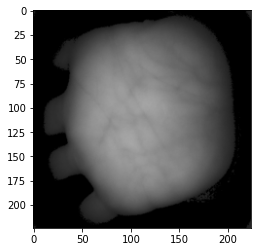

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

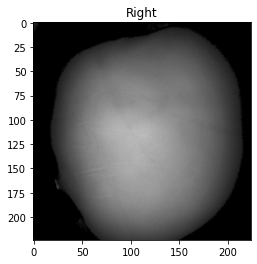

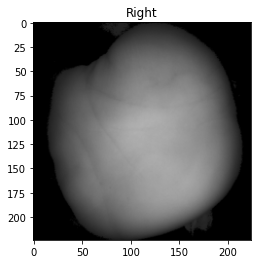

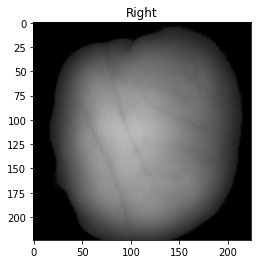

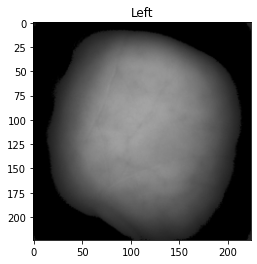

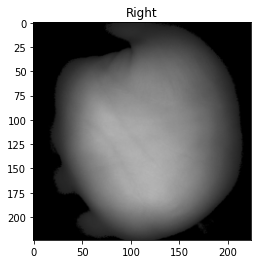

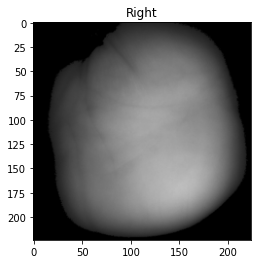

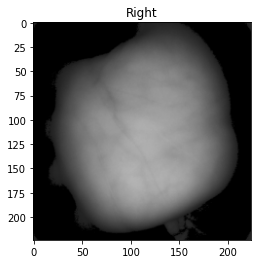

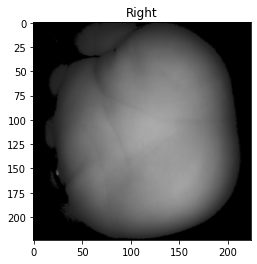

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [ ]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=15);

Epoch 0/14:


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/209 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slo

train Loss: 0.2731 Acc: 0.9025



100%|██████████| 42/42 [00:02<00:00, 20.96it/s]

val Loss: 0.1118 Acc: 0.9821
Epoch 1/14:



100%|██████████| 209/209 [00:07<00:00, 27.23it/s]

train Loss: 0.1467 Acc: 0.9563



100%|██████████| 42/42 [00:02<00:00, 20.48it/s]

val Loss: 0.0840 Acc: 0.9792
Epoch 2/14:



100%|██████████| 209/209 [00:07<00:00, 26.41it/s]

train Loss: 0.1557 Acc: 0.9474



100%|██████████| 42/42 [00:02<00:00, 20.03it/s]

val Loss: 0.0699 Acc: 0.9821
Epoch 3/14:



100%|██████████| 209/209 [00:07<00:00, 26.79it/s]

train Loss: 0.1089 Acc: 0.9629



100%|██████████| 42/42 [00:01<00:00, 21.04it/s]

val Loss: 0.0616 Acc: 0.9821
Epoch 4/14:



100%|██████████| 209/209 [00:07<00:00, 27.34it/s]

train Loss: 0.0978 Acc: 0.9695



100%|██████████| 42/42 [00:01<00:00, 21.40it/s]

val Loss: 0.0530 Acc: 0.9851
Epoch 5/14:



100%|██████████| 209/209 [00:07<00:00, 27.94it/s]

train Loss: 0.0823 Acc: 0.9731



100%|██████████| 42/42 [00:02<00:00, 15.12it/s]

val Loss: 0.0522 Acc: 0.9762
Epoch 6/14:



100%|██████████| 209/209 [00:08<00:00, 25.03it/s]

train Loss: 0.0818 Acc: 0.9755



100%|██████████| 42/42 [00:01<00:00, 21.39it/s]

val Loss: 0.0490 Acc: 0.9851
Epoch 7/14:



100%|██████████| 209/209 [00:09<00:00, 22.94it/s]

train Loss: 0.0928 Acc: 0.9707



100%|██████████| 42/42 [00:02<00:00, 14.34it/s]

val Loss: 0.0558 Acc: 0.9821
Epoch 8/14:



100%|██████████| 209/209 [00:10<00:00, 19.64it/s]

train Loss: 0.0695 Acc: 0.9821



100%|██████████| 42/42 [00:02<00:00, 14.61it/s]

val Loss: 0.0523 Acc: 0.9792
Epoch 9/14:



100%|██████████| 209/209 [00:10<00:00, 20.36it/s]

train Loss: 0.0852 Acc: 0.9689



100%|██████████| 42/42 [00:02<00:00, 20.97it/s]


val Loss: 0.0535 Acc: 0.9881
Epoch 10/14:


100%|██████████| 209/209 [00:07<00:00, 27.10it/s]

train Loss: 0.0810 Acc: 0.9785



100%|██████████| 42/42 [00:02<00:00, 20.95it/s]

val Loss: 0.0472 Acc: 0.9881


Epoch 11/14:


100%|██████████| 209/209 [00:07<00:00, 27.09it/s]

train Loss: 0.0901 Acc: 0.9707



100%|██████████| 42/42 [00:02<00:00, 20.95it/s]


val Loss: 0.0632 Acc: 0.9821
Epoch 12/14:


100%|██████████| 209/209 [00:07<00:00, 26.67it/s]

train Loss: 0.0778 Acc: 0.9743



100%|██████████| 42/42 [00:02<00:00, 20.73it/s]

val Loss: 0.0505 Acc: 0.9851
Epoch 13/14:



100%|██████████| 209/209 [00:07<00:00, 27.51it/s]

train Loss: 0.0791 Acc: 0.9731



100%|██████████| 42/42 [00:02<00:00, 20.95it/s]

val Loss: 0.0578 Acc: 0.9792
Epoch 14/14:



100%|██████████| 209/209 [00:07<00:00, 27.09it/s]

train Loss: 0.0834 Acc: 0.9689



100%|██████████| 42/42 [00:01<00:00, 21.30it/s]

val Loss: 0.0469 Acc: 0.9881


In [ ]:
test_dir = 'test_image'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test_image/unknown'

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/content/test_image', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 933
    Root location: /content/test_image
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 117/117 [00:06<00:00, 16.87it/s]


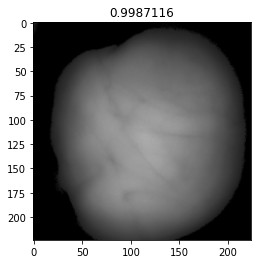

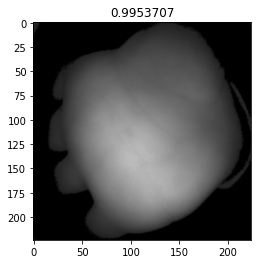

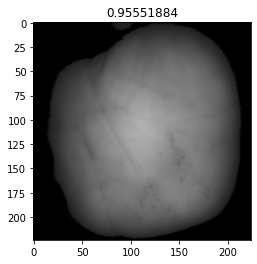

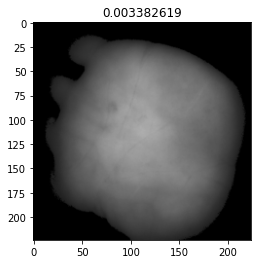

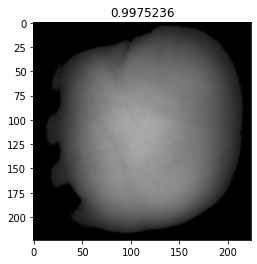

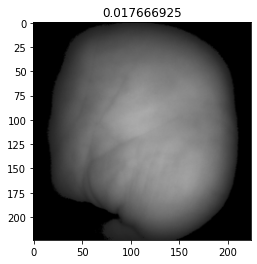

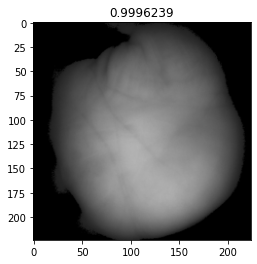

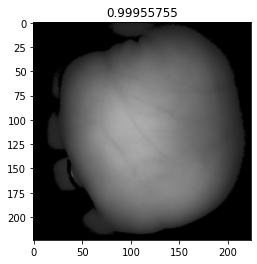

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': [x for x in range(len(test_predictions))],'FileName':test_img_paths,'label': test_predictions}) 

In [ ]:
submission_df

,id,FileName,label
0,0,/content/test_image/unknown/test (1).png,0.998712
1,1,/content/test_image/unknown/test (10).png,0.995371
2,2,/content/test_image/unknown/test (100).png,0.955519
3,3,/content/test_image/unknown/test (101).png,0.003383
4,4,/content/test_image/unknown/test (102).png,0.997524
...,...,...,...
928,928,/content/test_image/unknown/test (95).png,0.993468
929,929,/content/test_image/unknown/test (96).png,0.994481
930,930,/content/test_image/unknown/test (97).png,0.998026
931,931,/content/test_image/unknown/test (98).png,0.960644


In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'Right' if pred > 0.50 else 'Left')
submission_df['FileName'] = submission_df['FileName'].str.replace('/content/test_image/unknown/', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,FileName,label
id,,
0,test (1).png,Right
1,test (10).png,Right
2,test (100).png,Right
3,test (101).png,Left
4,test (102).png,Right
5,test (103).png,Left


In [ ]:
df_test_truth = pd.read_csv('/content/test/label.csv', delimiter=';')

In [ ]:
df_test_truth

,FileName,Angle,Side
0,test (1).png,190.103,Right
1,test (10).png,201.600,Right
2,test (100).png,192.389,Right
3,test (101).png,161.677,Left
4,test (102).png,189.604,Right
...,...,...,...
928,test (95).png,193.342,Right
929,test (96).png,191.456,Right
930,test (97).png,192.153,Right
931,test (98).png,194.690,Right


In [ ]:
name_to_label_test_truth = {}

for i, row in df_test_truth.iterrows():
  name_to_label_test_truth[row[0]] = row[2]

In [ ]:
count = 0
for i, row in submission_df.iterrows():
  if name_to_label_test_truth[row[0]]==row[1]:
    count+=1


print(f"Accuracy {count/len(submission_df)}")

Accuracy 0.992497320471597
